In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json


In [5]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 30.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain
import networkx as nx
from itertools import combinations
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter
import seaborn as sns
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
chunks = pd.read_json("/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json", lines=True, chunksize=100000)
dfs = []
for chunk in chunks:
    dfs.append(chunk)
df = pd.concat(dfs, ignore_index=True)

In [8]:
df2=df.copy(deep=True)

In [9]:
df2=df2.drop(['id','comments','journal-ref','doi','report-no','license','versions','abstract'],axis=1)

In [10]:
df2.isna().sum()

submitter         15186
authors               0
title                 0
categories            0
update_date           0
authors_parsed        0
dtype: int64

In [11]:
df2.head()

,submitter,authors,title,categories,update_date,authors_parsed
0,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,hep-ph,2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,math.CO cs.CG,2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,physics.gen-ph,2008-01-13,"[[Pan, Hongjun, ]]"
3,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,math.CO,2007-05-23,"[[Callan, David, ]]"
4,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [12]:
df2['update_date']=pd.to_datetime(df2['update_date'], errors='coerce')
df2['year'] = df2['update_date'].dt.year

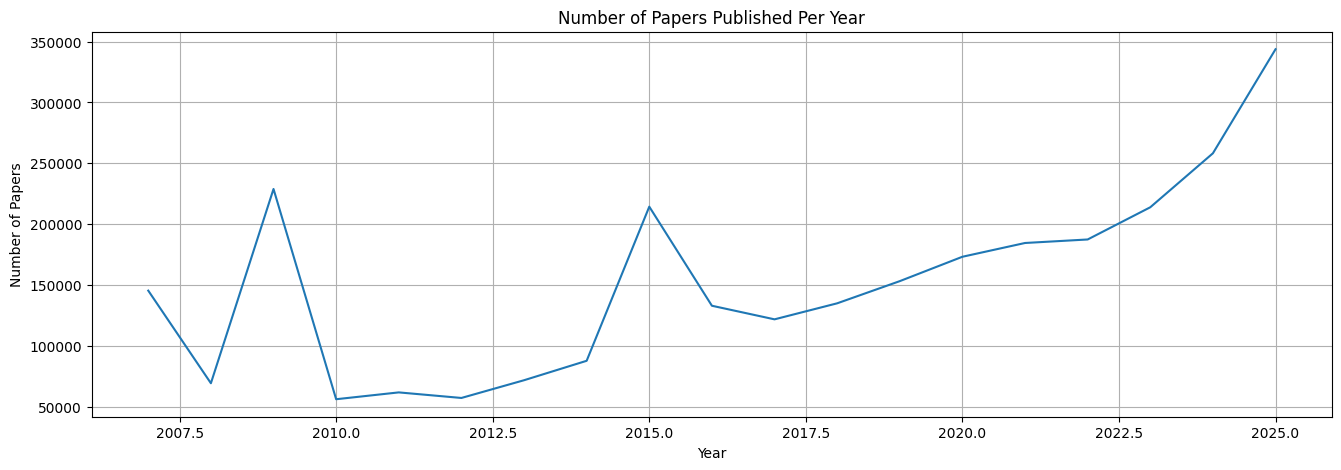

In [13]:
papers_per_year = df2.groupby('year').size()
plt.figure(figsize=(16,5))
papers_per_year.plot()
plt.title("Number of Papers Published Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.grid(True)
plt.show()

In [14]:
growth_rate = papers_per_year.pct_change() * 100
growth_rate

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


year
2007           NaN
2008    -52.367420
2009    230.590989
2010    -75.488213
2011      9.999287
2012     -7.412930
2013     25.494933
2014     22.282199
2015    144.462695
2016    -37.986543
2017     -8.405189
2018     10.813653
2019     13.512331
2020     13.078686
2021      6.535801
2022      1.565016
2023     14.128567
2024     20.741808
2025     33.119013
dtype: float64

In [15]:
df2['category_list'] = df2['categories'].str.split()

In [16]:
from collections import Counter
from itertools import chain
cat_counts = Counter(chain.from_iterable(df2['category_list']))
cat_df = pd.DataFrame(cat_counts.items(), columns=['category', 'count']).sort_values('count', ascending=False)
cat_df.head(20)

,category,count
96,cs.LG,243308
0,hep-ph,191949
13,hep-th,178095
114,cs.CV,174689
27,quant-ph,170656
42,cs.AI,152693
7,gr-qc,117826
9,astro-ph,105380
8,cond-mat.mtrl-sci,104297
6,cond-mat.mes-hall,98417


In [17]:
df_exploded=df2.explode('category_list')
cat_year=df_exploded.groupby(['year','category_list']).size().unstack(fill_value=0)

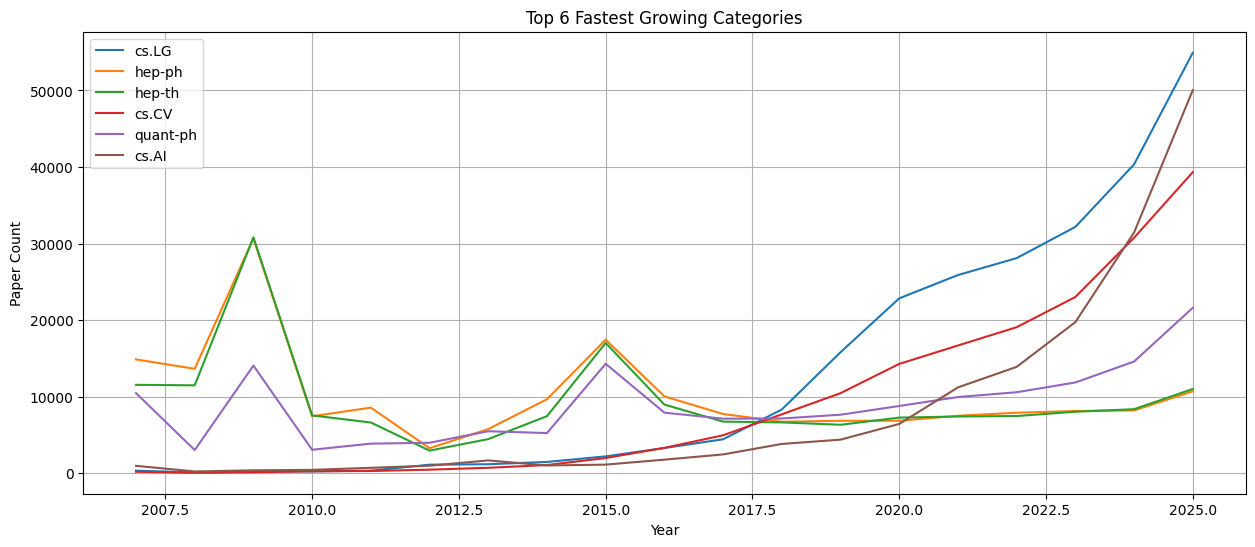

In [18]:
plt.figure(figsize=(15,6))
top_cats = cat_df.head(6)['category']
for cat in top_cats:
    trend = df_exploded[df_exploded['category_list'] == cat].groupby('year').size()
    plt.plot(trend.index, trend.values, label=cat)
plt.title("Top 6 Fastest Growing Categories")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.legend()
plt.grid(True)
plt.show()

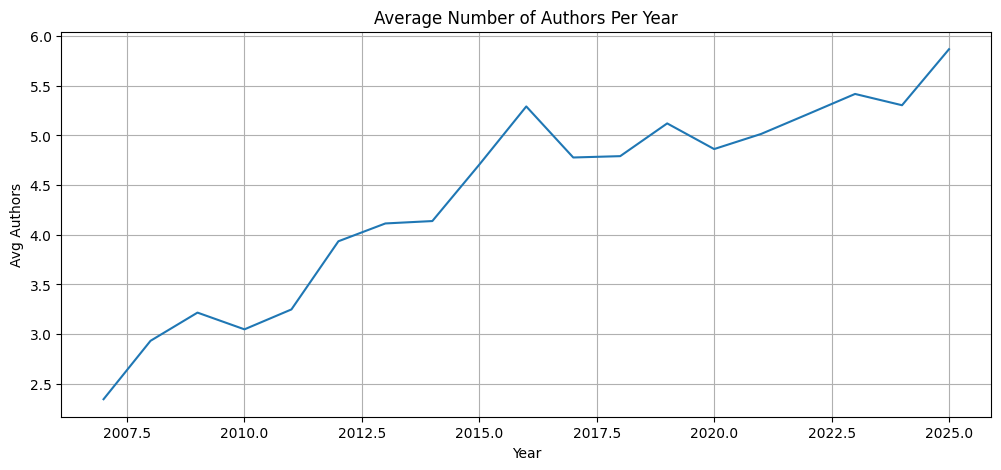

In [19]:
df2['n_authors']=df2['authors_parsed'].apply(len)
avg_authors_year = df2.groupby('year')['n_authors'].mean()
plt.figure(figsize=(12,5))
avg_authors_year.plot()
plt.title("Average Number of Authors Per Year")
plt.xlabel("Year")
plt.ylabel("Avg Authors")
plt.grid(True)
plt.show()

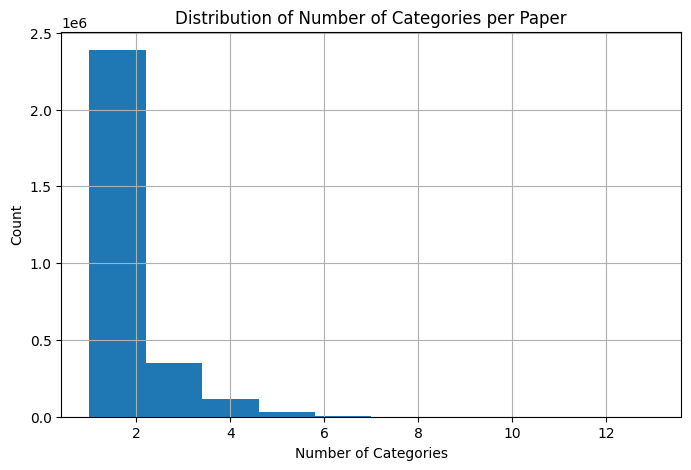

In [20]:
df2['n_categories'] = df2['category_list'].apply(len)
df2['n_categories'].hist(bins=10, figsize=(8,5))
plt.title("Distribution of Number of Categories per Paper")
plt.xlabel("Number of Categories")
plt.ylabel("Count")
plt.show()

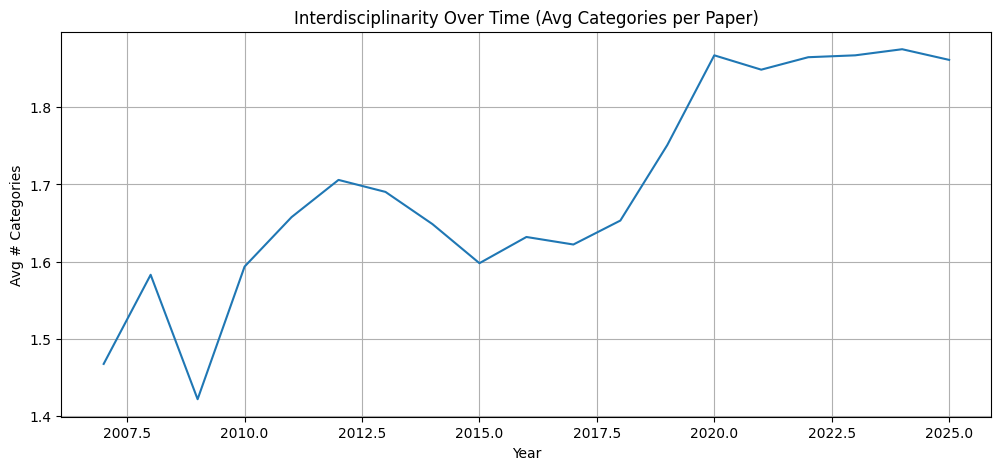

In [21]:
inter_year = df2.groupby('year')['n_categories'].mean()
plt.figure(figsize=(12,5))
inter_year.plot()
plt.title("Interdisciplinarity Over Time (Avg Categories per Paper)")
plt.xlabel("Year")
plt.ylabel("Avg # Categories")
plt.grid(True)
plt.show()

In [22]:
df2['clean_title'] = df2['title'].str.lower()
df2['clean_title'] = df2['clean_title'].str.replace(r'[^a-z0-9\s]', '', regex=True)

In [23]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
X = tfidf.fit_transform(df2['clean_title'])
keywords = tfidf.get_feature_names_out()
keywords[:50]

array(['analysis', 'approach', 'based', 'black', 'control', 'dark',
       'data', 'deep', 'detection', 'dynamics', 'effect', 'effects',
       'energy', 'equation', 'equations', 'estimation', 'field', 'finite',
       'functions', 'generation', 'language', 'large', 'learning',
       'linear', 'magnetic', 'matter', 'method', 'model', 'models',
       'network', 'networks', 'neural', 'new', 'nonlinear',
       'optimization', 'phase', 'problem', 'properties', 'quantum',
       'random', 'space', 'spin', 'state', 'states', 'structure', 'study',
       'systems', 'theory', 'time', 'using'], dtype=object)

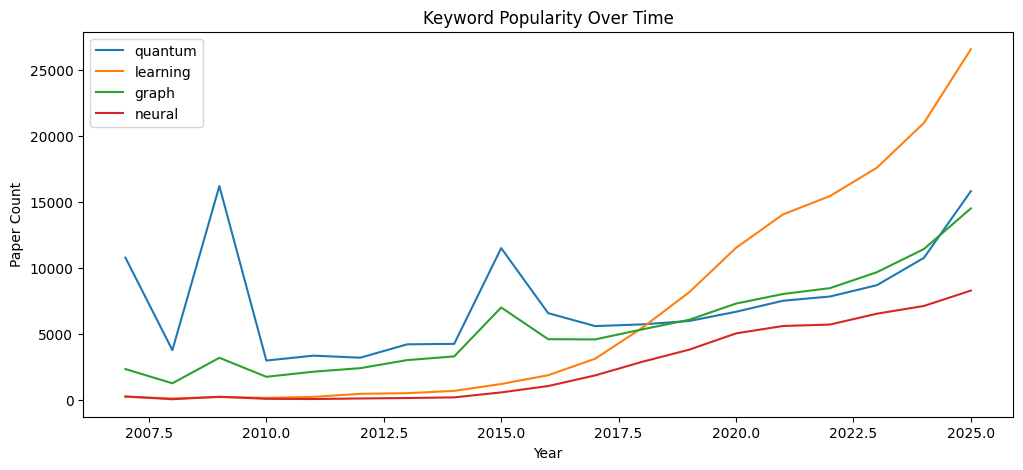

In [24]:
keywords_to_track = ['quantum', 'learning', 'graph', 'neural']
trend_df = pd.DataFrame(index=df2['year'].unique())
for kw in keywords_to_track:
    trend_df[kw] = df2[df2['clean_title'].str.contains(kw)]['year'].value_counts()
trend_df = trend_df.fillna(0).sort_index()
plt.figure(figsize=(12,5))
for kw in keywords_to_track:
    plt.plot(trend_df.index, trend_df[kw], label=kw)
plt.title("Keyword Popularity Over Time")
plt.xlabel("Year")
plt.ylabel("Paper Count")
plt.legend()
plt.show()

In [25]:
all_authors = Counter(chain.from_iterable(
    [[f"{a[0]} {a[1]}" for a in row] for row in df2['authors_parsed']]
))
TOP_N = 100
top_authors = set([name for name, count in all_authors.most_common(TOP_N)])
print("Top authors:", len(top_authors))
def contains_top_author(authors):
    for a in authors:
        full = f"{a[0]} {a[1]}"
        if full in top_authors:
            return True
    return False
filtered_df = df2[df2['authors_parsed'].apply(contains_top_author)]
print("Filtered rows:", len(filtered_df))
G = nx.Graph()
for authors in filtered_df['authors_parsed']:
    names = [f"{a[0]} {a[1]}" for a in authors if f"{a[0]} {a[1]}" in top_authors]
    if len(names) > 1:
        for a1, a2 in combinations(names, 2):
            G.add_edge(a1, a2)

Top authors: 100
Filtered rows: 61418


In [26]:
from pyvis.network import Network
net = Network(height="800px", width="100%", notebook=True, bgcolor="#111", font_color="white")
for node in G.nodes():
    net.add_node(node, label=node)
for u, v in G.edges():
    net.add_edge(u, v)
net.force_atlas_2based() 
net.show("coauthor_network.html")

coauthor_network.html


# **FOR EVALUATION THREE**

In [27]:
def normalize_versions_column(col):
    out = []
    for v in col:
        if isinstance(v, list):
            out.append(v)

        elif isinstance(v, np.ndarray):
            out.append(v.tolist())

        elif isinstance(v, str):
            try:
                parsed = ast.literal_eval(v)
                if isinstance(parsed, list):
                    out.append(parsed)
                else:
                    out.append([])
            except Exception:
                out.append([])

        else:
            out.append([])

    return out


df["versions_clean"] = normalize_versions_column(df["versions"])

def extract_first_last_created(vlist):
    if not vlist:
        return None, None

    created = [item.get("created") for item in vlist if isinstance(item, dict) and "created" in item]
    if not created:
        return None, None

    return created[0], created[-1]


first_dates = []
last_dates = []

for vlist in df["versions_clean"]:
    f, l = extract_first_last_created(vlist)
    first_dates.append(f)
    last_dates.append(l)

df["first_created_str"] = first_dates
df["last_created_str"] = last_dates

df["first_version_date"] = pd.to_datetime(df["first_created_str"], errors="coerce")
df["last_version_date"]  = pd.to_datetime(df["last_created_str"], errors="coerce")

df["update_date_parsed"] = pd.to_datetime(df["update_date"], errors="coerce")

df["pub_date"] = df["first_version_date"].fillna(df["update_date_parsed"])

df["year"] = df["pub_date"].dt.year.astype("Int64")

df["author_list"] = df["authors"].fillna("").astype(str).apply(lambda x: [a.strip() for a in re.split(r",| and |;", x) if a.strip()])

df["num_authors"] = df["author_list"].apply(len)

df["category_list"] = df["categories"].fillna("").astype(str).apply(lambda x: x.split())

# Author Collaboration Size Trend (are teams getting larger?)

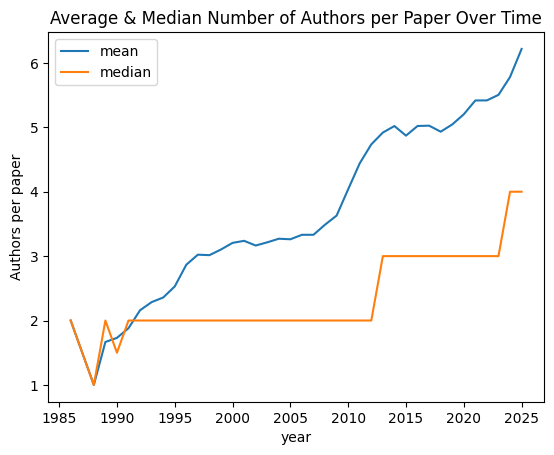

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


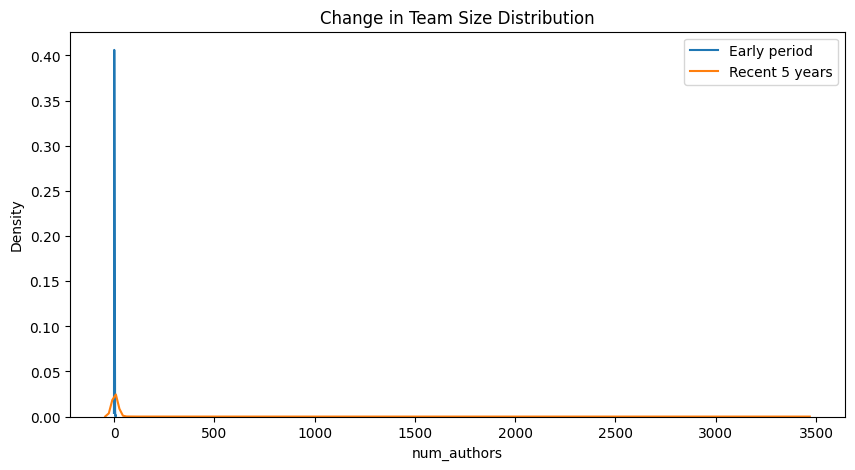

In [29]:
collab = df.groupby('year')['num_authors'].agg(['mean','median','count']).dropna()
collab[['mean','median']].plot()
plt.title("Average & Median Number of Authors per Paper Over Time")
plt.ylabel("Authors per paper")
plt.show()
recent = df[df['year'] >= (df['year'].max() - 5)]['num_authors']
older = df[df['year'] <= (df['year'].min() + 5)]['num_authors']
plt.figure(figsize=(10,5))
sns.kdeplot(older.dropna(), label='Early period', bw_method=0.5)
sns.kdeplot(recent.dropna(), label='Recent 5 years', bw_method=0.5)
plt.title("Change in Team Size Distribution")
plt.legend()
plt.show()


# Lotka’s Law / Author Productivity Distribution

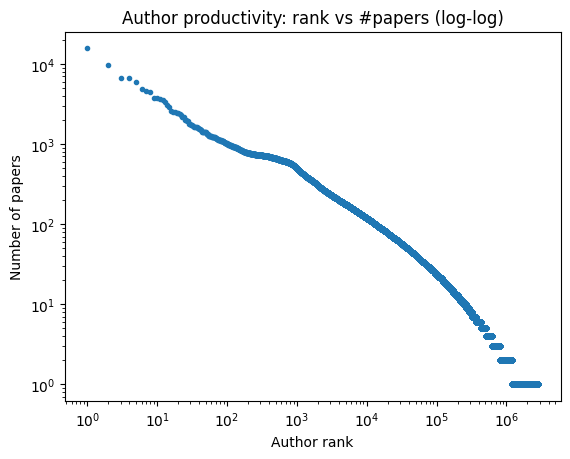

In [30]:
all_authors = []
df['author_list'].apply(lambda al: all_authors.extend(al))
author_counts = pd.Series(Counter([a for a in all_authors if a]).values())
author_counts = author_counts.sort_values(ascending=False)
plt.loglog(range(1, len(author_counts)+1), author_counts.values, marker='.', linestyle='none')
plt.title("Author productivity: rank vs #papers (log-log)")
plt.xlabel("Author rank")
plt.ylabel("Number of papers")
plt.show()
summary = {
    'total_authors': len(author_counts),
    'authors_with_1_paper_pct': (author_counts==1).mean()*100,
    'authors_with_5_plus_pct': (author_counts>=5).mean()*100
}

# Category Co-occurrence Network (interdisciplinarity)

In [32]:
from itertools import combinations
from collections import Counter

# Build category co-occurrence counts
multi = df[df['category_list'].apply(lambda x: len(x) > 1)]
co_count = Counter()

for cats in multi['category_list']:
    for a, b in combinations(sorted(set(cats)), 2):
        co_count[(a, b)] += 1


In [33]:
net = Network(height="750px", width="100%", notebook=True)
net.barnes_hut() 
for (a,b), cnt in co_count.most_common(100):
    net.add_node(a, label=a)
    net.add_node(b, label=b)
    net.add_edge(a, b, value=cnt, title=f"Co-occurrences: {cnt}")
net.set_options("""
var options = {
  "nodes": {
    "shape": "dot",
    "size": 20
  },
  "edges": {
    "smooth": false,
    "scaling": {
      "min": 1,
      "max": 20
    }
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -15000
    },
    "minVelocity": 0.75
  }
}
""")
net.show("category_cooccurrence.html")

category_cooccurrence.html


**Topic Modeling (LDA) to find latent topics and their time trajectories**

# Topic Modeling (LDA) to find latent topics and their time trajectories

,Topic,Top Words
0,Topic 0,"quantum, photon, single, state, optical, state..."
1,Topic 1,"equation, space, quantum, equations, time, met..."
2,Topic 2,"field, atom, time, atoms, state, wave, level, ..."
3,Topic 3,"quantum, state, states, protocol, entanglement..."
4,Topic 4,"spin, states, state, particle, entanglement, s..."
5,Topic 5,"quantum, theory, mechanics, classical, time, m..."
6,Topic 6,"quantum, algorithm, error, computation, proble..."
7,Topic 7,"states, entanglement, quantum, state, entropy,..."


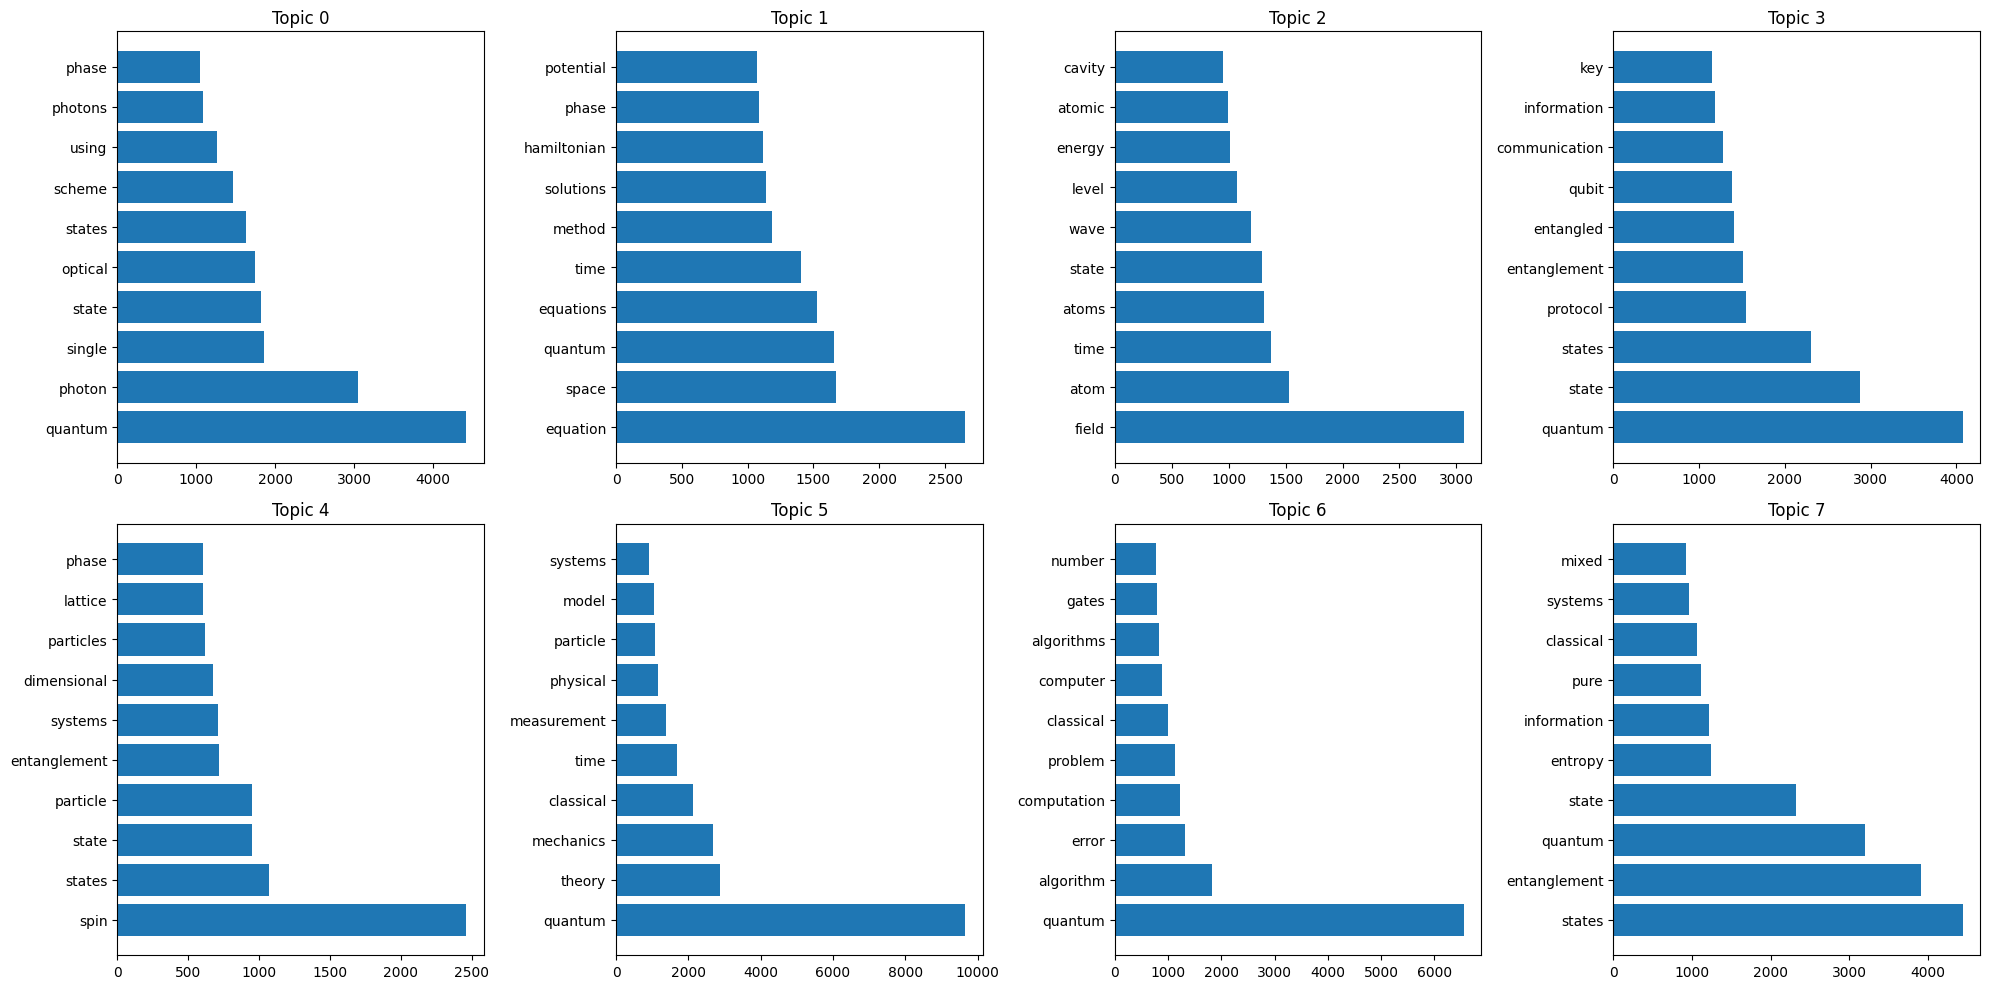

In [34]:
docs = df['abstract'].fillna('').astype(str).values
N = min(len(docs), 20000)
docs = docs[-N:]
count_vect = CountVectorizer(max_df=0.95, min_df=5, stop_words='english', max_features=2000)
X_counts = count_vect.fit_transform(docs)
n_topics = 8
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=10,
    learning_method='batch'
)
lda.fit(X_counts)
words = count_vect.get_feature_names_out()
topic_data = []
num_top_words = 10
for i, comp in enumerate(lda.components_):
    terms = [words[idx] for idx in comp.argsort()[-num_top_words:][::-1]]
    topic_data.append([f"Topic {i}", ", ".join(terms)])
topic_df = pd.DataFrame(topic_data, columns=["Topic", "Top Words"])
display(topic_df)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    comp = lda.components_[i]
    idx = comp.argsort()[-num_top_words:]
    top_terms = [words[j] for j in idx]
    top_values = comp[idx]

    ax.barh(top_terms, top_values)
    ax.set_title(f"Topic {i}")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


# Preprint → Published: fraction of arXiv preprints that are eventually published (via journal-ref) and time-to-publication

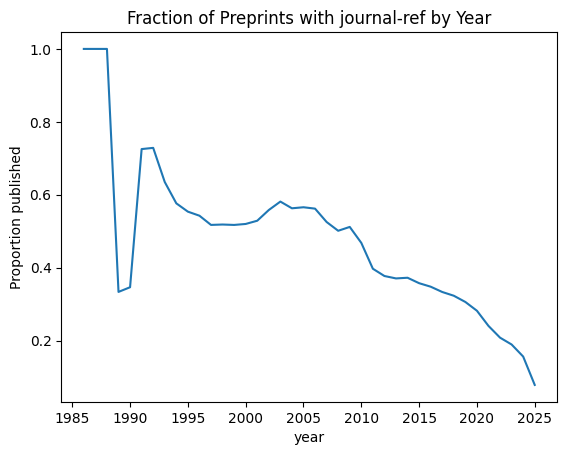

count    919937.000000
mean       1083.189302
std        1530.941339
min           0.000000
25%         111.000000
50%         358.000000
75%        1490.000000
max       12640.000000
Name: time_to_update_days, dtype: float64

In [35]:
df['is_published'] = df['journal-ref'].notna() & (df['journal-ref'].astype(str).str.strip() != '')
pub_rate = df.groupby('year')['is_published'].mean().dropna()
pub_rate.plot()
plt.title("Fraction of Preprints with journal-ref by Year")
plt.ylabel("Proportion published")
plt.show()
df['update_dt'] = df['update_date_parsed']  # reuse parsed date
mask = (
    df['is_published']
    & df['first_version_date'].notna()
    & df['update_dt'].notna()
)
df['time_to_update_days'] = np.where(
    mask,
    (df['update_dt'] - df['first_version_date']).dt.days,
    np.nan
)
df.loc[mask, 'time_to_update_days'].describe()


# Versioning / Revision Behavior: how often and how long do papers get revised

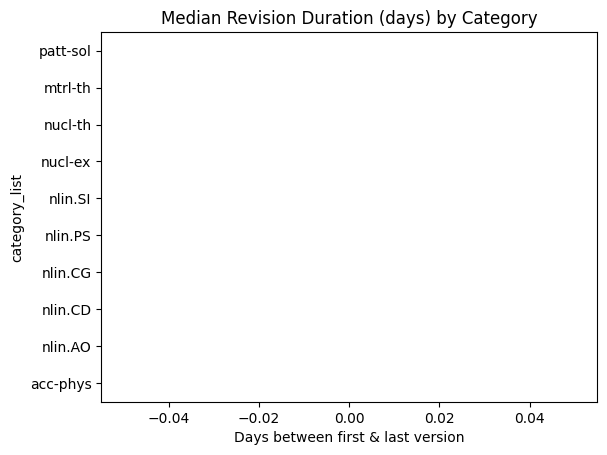

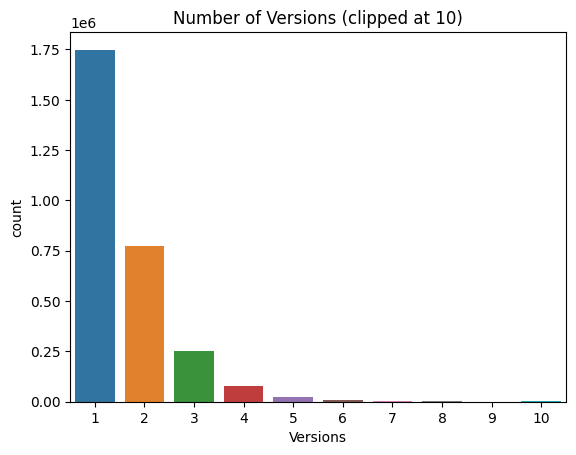

In [36]:
df['num_versions'] = df['versions_clean'].str.len()
df['revision_days'] = (
    df['last_version_date'] - df['first_version_date']
).dt.days.fillna(0).astype(int)
rev_cat = (
    df.explode('category_list')
      .groupby('category_list')['revision_days']
      .median()
      .sort_values()
)
rev_cat.head(10).plot(kind='barh')
plt.title("Median Revision Duration (days) by Category")
plt.xlabel("Days between first & last version")
plt.show()
sns.countplot(x=np.clip(df['num_versions'], 0, 10))
plt.title("Number of Versions (clipped at 10)")
plt.xlabel("Versions")
plt.show()


In [41]:
df['revision_days_raw'] = (df['last_version_date'] - df['first_version_date']).dt.days
df['revision_days'] = df['revision_days_raw'].where(
    (df['revision_days_raw'] >= 0) &
    (df['revision_days_raw'] <= 2000),  
    np.nan
)

In [42]:
df['num_versions'].value_counts().head(10)
df['revision_days'].describe()

count    2.885525e+06
mean     9.376599e+01
std      2.128168e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.700000e+01
max      2.000000e+03
Name: revision_days, dtype: float64